# Hyperparameter Optimization
- with Weights and Bias, https://wandb.ai/site
- Note that this notebook was originally ran on Kaggle in separate versions. This notebook reflects Version 6, which has the output of XLNet. For the output of BERT and RoBERTa, refer to Version 4 and 5 of this [Kaggle Notebook](https://www.kaggle.com/wushennn/ml-transfer-learning-fine-tuning) 
- Alternatively, results of hyperparameter tuning over the number of epcohs and learning rate can be visualized in the following links: [BERT](https://wandb.ai/datasiens/bert_original_train/sweeps/5v6557nj?workspace=user-), [RoBERTa](https://wandb.ai/datasiens/roberta_original_train/sweeps/eluhck1w?workspace=user-), [XLNet](https://wandb.ai/datasiens/xlnet_original_train/sweeps/bylsapm6?workspace=user-)

In [ ]:
!pip install -qq wandb
!pip install -qq transformers
!pip install -qq simpletransformers

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dask-cudf 21.8.3 requires cupy-cuda114, which is not installed.
distributed 2021.7.1 requires dask==2021.07.1, but you have dask 2021.10.0 which is incompatible.
dask-cudf 21.8.3 requires dask<=2021.07.1,>=2021.6.0, but you have dask 2021.10.0 which is incompatible.
dask-cudf 21.8.3 requires pandas<1.3.0dev0,>=1.0, but you have pandas 1.3.4 which is incompatible.
allennlp 2.7.0 requires transformers<4.10,>=4.1, but you have transformers 4.12.3 which is incompatible.


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
import logging
from statistics import mean, mode
import wandb
from simpletransformers.classification import ClassificationArgs, ClassificationModel

## Load Train and Validation Data

In [ ]:
# Train data: with back translation augmentation
train = pd.read_csv('../input/mlproject/original_train.csv')
# train.drop(columns=['Unnamed: 0'], inplace=True)

# Add 1 to sentiment label, unable to feed negative label (0: negative, 1: neutral, 2: positive)
train['sentiment'] = train['sentiment'].apply(lambda x: x + 1)

# Validation
validation = pd.read_csv('../input/mlproject/validation.csv')
validation.drop(columns=['Unnamed: 0', 'index', 'lemmatized and stopwords_removed'], inplace=True)
validation['sentiment'] = validation['sentiment'].apply(lambda x: x + 1)

In [ ]:
train.head()

,text,sentiment
0,should uber use driverless cars to ease safety...,1
1,oh hai minorityreport is making your driverles...,1
2,who is responsible if a self driving car gets ...,1
3,i almost got rear ended by the google car iron...,0
4,self driving cars will be a hit until the firs...,0


In [ ]:
validation.head()

,text,sentiment
0,i think my timeline is aggressive but they com...,1
1,google car has no steering wheel or pedals you...,1
2,saw the google car around pm at byron at golde...,2
3,is it crazy to think that self driving cars wi...,2
4,ive moved about in the last twenty minutes the...,2


In [ ]:
print('Dataset shape:')
print(train.shape)
print(validation.shape)

Dataset shape:
(5360, 2)
(670, 2)


<AxesSubplot:xlabel='sentiment'>

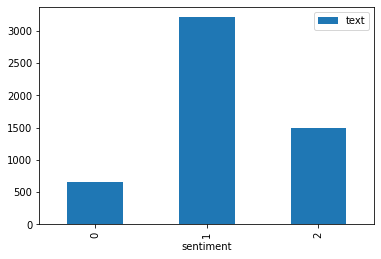

In [ ]:
# Train distribution
train.groupby('sentiment').count().plot.bar()

<AxesSubplot:xlabel='sentiment'>

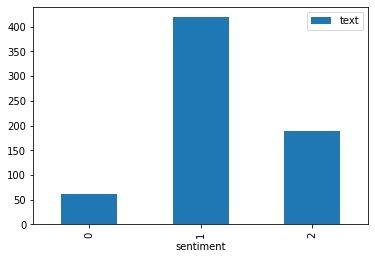

In [ ]:
# Validation distribution
validation.groupby('sentiment').count().plot.bar()

## WandB Login
Connect to WandB with apikey to use their services

In [ ]:
# WandB apikey: 8afe8d7e3e0a18ca1854c9fe7f4bbd7c07a3844b

In [ ]:
wandb.login()

wandb: You can find your API key in your browser here: https://wandb.ai/authorize


wandb: Paste an API key from your profile and hit enter:  ···················


wandb: ERROR API key must be 40 characters long, yours was 19
wandb: You can find your API key in your browser here: https://wandb.ai/authorize


wandb: Paste an API key from your profile and hit enter:  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

# BERT

**BERT Sweep Config**

Set up the sweep configuration, in this case, we are using the following parameters:
1. **Bayesian search** method
2. Evaluating **accuracy** of each model
3. Number of training epochs of 2-5 and learning rate of 1e-5 to 4e-4
4. Set up early stopping 

In [ ]:
sweep_config = {
    "method": "bayes",  # grid, random
    "metric": {"name": "accuracy", "goal": "maximize"},
    "parameters": {
        "num_train_epochs": {"min": 2, "max": 5},
        "learning_rate": {"min": 1e-5, "max": 4e-4},
    },
    "early_terminate": {"type": "hyperband", "min_iter": 6,},
}

sweep_id = wandb.sweep(sweep_config, project="bert_original_train")

logging.basicConfig(level=logging.INFO)
transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.WARNING)

**BERT Model Arugment**

Model is set up with the following arguments, 
- manual_seed set to 4 to ensure results are reproducible 

In [ ]:
model_args = ClassificationArgs()
model_args.reprocess_input_data = True
model_args.overwrite_output_dir = True
model_args.evaluate_during_training = True
model_args.manual_seed = 4
model_args.use_multiprocessing = True
model_args.train_batch_size = 32
model_args.labels_list = [0, 1, 2]
model_args.eval_batch_size = 16
model_args.no_cache = True
model_args.no_save = True
model_args.wandb_project = "bert_original_train"

Define helper function to train the model 

In [ ]:
def model_train_bert():
    # Initialize a new wandb run
    wandb.init()

    # Create a TransformerModel
    model = ClassificationModel(
        "bert",
        "bert-base-uncased",
        num_labels=3,
        use_cuda=True,
        args=model_args,
        sweep_config=wandb.config,
    )

    # Train the model
    model.train_model(
        train,
        eval_df=validation,
        accuracy=lambda truth, predictions: accuracy_score(
            truth, [round(p) for p in predictions]
        ),
    )
    
    # Sync wandb
    wandb.join()

Call WandB.agent to run the helper function. 

WandB.agent is a generic agent entrypoint, used for CLI or jupyter. 

Results of the sweep can be viewed: https://wandb.ai/datasiens/bert_original_train/sweeps/5v6557nj?workspace=user-

In [ ]:
wandb.agent(sweep_id, model_train_bert)

# Roberta

**Roberta Sweep Config**

Set up the sweep configuration, in this case, we are using the following parameters:
1. **Bayesian search** method
2. Evaluating **accuracy** of each model
3. Number of training epochs of 2-10 and learning rate of 1e-5 to 4e-4
4. Set up early stopping 

In [ ]:
sweep_config = {
    "method": "bayes", 
    "metric": {"name": "accuracy", "goal": "maximize"},
    "parameters": {
        "num_train_epochs": {"min": 2, "max": 10},
        "learning_rate": {"min": 1e-5, "max": 4e-4},
    },
    "early_terminate": {"type": "hyperband", "min_iter": 5,},
}

sweep_id = wandb.sweep(sweep_config, project="roberta_original_train")

logging.basicConfig(level=logging.INFO)
transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.WARNING)

**Roberta Model Arguments**

Model is set up with the following arguments, 
- manual_seed set to 4 to ensure results are reproducible 

In [ ]:
model_args = ClassificationArgs()
model_args.reprocess_input_data = True
model_args.overwrite_output_dir = True
model_args.evaluate_during_training = True
model_args.manual_seed = 4
model_args.use_multiprocessing = True
model_args.train_batch_size = 32
model_args.labels_list = [0, 1, 2]
model_args.eval_batch_size = 16
model_args.no_cache = True
model_args.no_save = True
model_args.wandb_project = "roberta_original_train"

Define helper function to train the model

In [ ]:
def model_train():
    # Initialize a new wandb run
    wandb.init()

    # Create a TransformerModel
    model = ClassificationModel(
        "roberta",
        "roberta-base",
        num_labels=3,
        use_cuda=True,
        args=model_args,
        sweep_config=wandb.config,
    )

    # Train the model
    model.train_model(
        train,
        eval_df=validation,
        accuracy=lambda truth, predictions: accuracy_score(
            truth, [round(p) for p in predictions]
        ),
    )
    
    # Sync wandb
    wandb.join()

Call WandB.agent to run the helper function. 

WandB.agent is a generic agent entrypoint, used for CLI or jupyter. 

Results of the sweep can be viewed: https://wandb.ai/datasiens/roberta_original_train/sweeps/eluhck1w?workspace=user-

In [ ]:
wandb.agent(sweep_id, model_train)

# XLNet
List of community models for XLNet can be found on [Hugging Face](https://huggingface.co/models?sort=downloads&search=xlnet)

We will use the most popular **xlnet-base-cased**

**XLNet Sweep Config**

Set up the sweep configuration, in this case, we are using the following parameters:
1. **Bayesian search** method
2. Evaluating **accuracy** of each model
3. Number of training epochs of 2-6 and learning rate of 1e-5 to 4e-4
4. Set up early stopping 

In [ ]:
sweep_config = {
    "method": "bayes",  # grid, random
    "metric": {"name": "accuracy", "goal": "maximize"},
    "parameters": {
        "num_train_epochs": {"min": 2, "max": 6},
        "learning_rate": {"min": 1e-5, "max": 4e-4},
    },
    "early_terminate": {"type": "hyperband", "min_iter": 5,},
}

sweep_id = wandb.sweep(sweep_config, project="xlnet_original_train")

logging.basicConfig(level=logging.INFO)
transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.WARNING)

Create sweep with ID: bylsapm6
Sweep URL: https://wandb.ai/datasiens/xlnet_original_train/sweeps/bylsapm6


**XLNet Model Arguments**

Model is set up with the following arguments, 
- manual_seed set to 4 to ensure results are reproducible 

In [ ]:
model_args = ClassificationArgs()
model_args.reprocess_input_data = True
model_args.overwrite_output_dir = True
model_args.evaluate_during_training = True
model_args.manual_seed = 4
model_args.use_multiprocessing = True
model_args.train_batch_size = 32
model_args.labels_list = [0, 1, 2]
model_args.eval_batch_size = 16
model_args.no_cache = True
model_args.no_save = True
model_args.wandb_project = "xlnet_original_train"

Define helper function to train the model

In [ ]:
def model_train_xlnet():
    # Initialize a new wandb run
    wandb.init()

    # Create a TransformerModel
    model = ClassificationModel(
        "xlnet",
        "xlnet-base-cased",
        num_labels=3,
        use_cuda=True,
        args=model_args,
        sweep_config=wandb.config,
    )

    # Train the model
    model.train_model(
        train,
        eval_df=validation,
        accuracy=lambda truth, predictions: accuracy_score(
            truth, [round(p) for p in predictions]
        ),
    )
    
    # Sync wandb
    wandb.join()

Call WandB.agent to run the helper function. 

WandB.agent is a generic agent entrypoint, used for CLI or jupyter. 

Results of the sweep can be viewed: https://wandb.ai/datasiens/xlnet_original_train/sweeps/bylsapm6?workspace=user-

In [ ]:
wandb.agent(sweep_id, model_train_xlnet)

wandb: Agent Starting Run: 3hf2bkrl with config:
wandb: 	learning_rate: 2.4070228708911732e-05
wandb: 	num_train_epochs: 2
wandb: Currently logged in as: datasiens (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.6 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade



CondaEnvException: Unable to determine environment

Please re-run this command with one of the following options:

* Provide an environment name via --name or -n
* Re-run this command inside an activated conda environment.



Downloading:   0%|          | 0.00/760 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/445M [00:00<?, ?B/s]

Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForSequenceClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.weight', 'sequence_summary.summary.bias', 'logits_proj.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions a

Downloading:   0%|          | 0.00/779k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.32M [00:00<?, ?B/s]

/opt/conda/lib/python3.7/site-packages/simpletransformers/classification/classification_model.py:586: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


  0%|          | 0/5360 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Running Epoch 0 of 2:   0%|          | 0/168 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/simpletransformers/classification/classification_model.py:922: FutureWarning: Non-finite norm encountered in torch.nn.utils.clip_grad_norm_; continuing anyway. Note that the default behavior will change in a future release to error out if a non-finite total norm is encountered. At that point, setting error_if_nonfinite=false will be required to retain the old behavior.
  model.parameters(), args.max_grad_norm
/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarnin

  0%|          | 0/670 [00:00<?, ?it/s]

Running Epoch 1 of 2:   0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/670 [00:00<?, ?it/s]

Training loss,▃▂▆▆▁█
accuracy,▁█
eval_loss,█▁
global_step,▁▂▃▄▅▆▇█
lr,█▇▅▄▂▁
mcc,▁█
train_loss,▁█
Training loss,0.85576
accuracy,0.74925
eval_loss,0.62675
global_step,336


wandb: Agent Starting Run: ohsnky21 with config:
wandb: 	learning_rate: 6.424577122953353e-05
wandb: 	num_train_epochs: 2
wandb: wandb version 0.12.6 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade

CondaEnvException: Unable to determine environment

Please re-run this command with one of the following options:

* Provide an environment name via --name or -n
* Re-run this command inside an activated conda environment.



Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForSequenceClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.weight', 'sequence_summary.summary.bias', 'logits_proj.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions a

  0%|          | 0/5360 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Running Epoch 0 of 2:   0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/670 [00:00<?, ?it/s]

Running Epoch 1 of 2:   0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/670 [00:00<?, ?it/s]

Training loss,▄▅█▆▁█
accuracy,▁█
eval_loss,█▁
global_step,▁▂▃▄▅▆▇█
lr,█▇▅▄▂▁
mcc,▁█
train_loss,█▁
Training loss,0.76481
accuracy,0.76567
eval_loss,0.58058
global_step,336


wandb: Agent Starting Run: xqwf78dx with config:
wandb: 	learning_rate: 0.0002244721323507937
wandb: 	num_train_epochs: 4
wandb: wandb version 0.12.6 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade

CondaEnvException: Unable to determine environment

Please re-run this command with one of the following options:

* Provide an environment name via --name or -n
* Re-run this command inside an activated conda environment.



Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForSequenceClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.weight', 'sequence_summary.summary.bias', 'logits_proj.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions a

  0%|          | 0/5360 [00:00<?, ?it/s]

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Running Epoch 0 of 4:   0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/670 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Running Epoch 1 of 4:   0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/670 [00:00<?, ?it/s]

Running Epoch 2 of 4:   0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/670 [00:00<?, ?it/s]

Running Epoch 3 of 4:   0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/670 [00:00<?, ?it/s]

Training loss,▁▂▃▅▃▆█▇▅▅▄▃▃
accuracy,▁▁▁▁
eval_loss,▇█▁▁
global_step,▁▂▂▂▃▃▄▄▄▅▆▆▆▇▇██
lr,█▇▇▆▆▅▅▄▃▃▂▂▁
mcc,▁▁▁▁
train_loss,▁▆█▇
Training loss,0.84342
accuracy,0.62537
eval_loss,0.87208
global_step,672


wandb: Agent Starting Run: ni9xbikx with config:
wandb: 	learning_rate: 0.00010255473530061908
wandb: 	num_train_epochs: 2
wandb: wandb version 0.12.6 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade

CondaEnvException: Unable to determine environment

Please re-run this command with one of the following options:

* Provide an environment name via --name or -n
* Re-run this command inside an activated conda environment.



Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForSequenceClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.weight', 'sequence_summary.summary.bias', 'logits_proj.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions a

  0%|          | 0/5360 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Running Epoch 0 of 2:   0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/670 [00:00<?, ?it/s]

Running Epoch 1 of 2:   0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/670 [00:00<?, ?it/s]

Training loss,▁▇█▅▄█
accuracy,█▁
eval_loss,█▁
global_step,▁▂▃▄▅▆▇█
lr,█▇▅▄▂▁
mcc,▁█
train_loss,█▁
Training loss,0.83216
accuracy,0.73284
eval_loss,0.67554
global_step,336


wandb: Agent Starting Run: 67zlueto with config:
wandb: 	learning_rate: 5.558427544161275e-05
wandb: 	num_train_epochs: 2
wandb: wandb version 0.12.6 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade

CondaEnvException: Unable to determine environment

Please re-run this command with one of the following options:

* Provide an environment name via --name or -n
* Re-run this command inside an activated conda environment.



Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForSequenceClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.weight', 'sequence_summary.summary.bias', 'logits_proj.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions a

  0%|          | 0/5360 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Running Epoch 0 of 2:   0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/670 [00:00<?, ?it/s]

Running Epoch 1 of 2:   0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/670 [00:00<?, ?it/s]

Training loss,▁▃█▆▁▅
accuracy,▁█
eval_loss,█▁
global_step,▁▂▃▄▅▆▇█
lr,█▇▅▄▂▁
mcc,▁█
train_loss,▁█
Training loss,0.73212
accuracy,0.76119
eval_loss,0.58653
global_step,336


wandb: Agent Starting Run: lqo81z4q with config:
wandb: 	learning_rate: 4.978449708925588e-05
wandb: 	num_train_epochs: 2
wandb: wandb version 0.12.6 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade

CondaEnvException: Unable to determine environment

Please re-run this command with one of the following options:

* Provide an environment name via --name or -n
* Re-run this command inside an activated conda environment.



Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForSequenceClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.weight', 'sequence_summary.summary.bias', 'logits_proj.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions a

  0%|          | 0/5360 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Running Epoch 0 of 2:   0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/670 [00:00<?, ?it/s]

Running Epoch 1 of 2:   0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/670 [00:00<?, ?it/s]

Training loss,▁▃▆▆▁█
accuracy,▁█
eval_loss,█▁
global_step,▁▂▃▄▅▆▇█
lr,█▇▅▄▂▁
mcc,▁█
train_loss,█▁
Training loss,0.88576
accuracy,0.75373
eval_loss,0.60566
global_step,336


wandb: Agent Starting Run: tf8crnac with config:
wandb: 	learning_rate: 5.444681210788344e-05
wandb: 	num_train_epochs: 2
wandb: wandb version 0.12.6 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade

CondaEnvException: Unable to determine environment

Please re-run this command with one of the following options:

* Provide an environment name via --name or -n
* Re-run this command inside an activated conda environment.



Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForSequenceClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.weight', 'sequence_summary.summary.bias', 'logits_proj.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions a

  0%|          | 0/5360 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Running Epoch 0 of 2:   0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/670 [00:00<?, ?it/s]

Running Epoch 1 of 2:   0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/670 [00:00<?, ?it/s]

Training loss,▁▂▆▅▁█
accuracy,▁█
eval_loss,█▁
global_step,▁▂▃▄▅▆▇█
lr,█▇▅▄▂▁
mcc,▁█
train_loss,▁█
Training loss,0.92135
accuracy,0.7597
eval_loss,0.58871
global_step,336


wandb: Agent Starting Run: 15toe3kt with config:
wandb: 	learning_rate: 3.931103040131295e-05
wandb: 	num_train_epochs: 2
wandb: wandb version 0.12.6 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade

CondaEnvException: Unable to determine environment

Please re-run this command with one of the following options:

* Provide an environment name via --name or -n
* Re-run this command inside an activated conda environment.



Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForSequenceClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.weight', 'sequence_summary.summary.bias', 'logits_proj.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions a

  0%|          | 0/5360 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Running Epoch 0 of 2:   0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/670 [00:00<?, ?it/s]

Running Epoch 1 of 2:   0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/670 [00:00<?, ?it/s]

Training loss,▃▂▅▇▁█
accuracy,▁▁
eval_loss,█▁
global_step,▁▂▃▄▅▆▇█
lr,█▇▅▄▂▁
mcc,▁█
train_loss,▁█
Training loss,0.86065
accuracy,0.75373
eval_loss,0.59888
global_step,336


wandb: Agent Starting Run: fsb3sycf with config:
wandb: 	learning_rate: 5.5961355884917234e-05
wandb: 	num_train_epochs: 2
wandb: wandb version 0.12.6 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade

CondaEnvException: Unable to determine environment

Please re-run this command with one of the following options:

* Provide an environment name via --name or -n
* Re-run this command inside an activated conda environment.



Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForSequenceClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.weight', 'sequence_summary.summary.bias', 'logits_proj.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions a

  0%|          | 0/5360 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Running Epoch 0 of 2:   0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/670 [00:00<?, ?it/s]

Running Epoch 1 of 2:   0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/670 [00:00<?, ?it/s]

Training loss,▃▄██▁▆
accuracy,▁█
eval_loss,█▁
global_step,▁▂▃▄▅▆▇█
lr,█▇▅▄▂▁
mcc,▁█
train_loss,█▁
Training loss,0.75112
accuracy,0.73582
eval_loss,0.6274
global_step,336


wandb: Agent Starting Run: 0oid5pyx with config:
wandb: 	learning_rate: 0.00010647636093532612
wandb: 	num_train_epochs: 3
wandb: wandb version 0.12.6 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade

CondaEnvException: Unable to determine environment

Please re-run this command with one of the following options:

* Provide an environment name via --name or -n
* Re-run this command inside an activated conda environment.



Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForSequenceClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.weight', 'sequence_summary.summary.bias', 'logits_proj.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions a

  0%|          | 0/5360 [00:00<?, ?it/s]

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 0 of 3:   0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/670 [00:00<?, ?it/s]

Running Epoch 1 of 3:   0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/670 [00:00<?, ?it/s]

Running Epoch 2 of 3:   0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/670 [00:00<?, ?it/s]

Training loss,▁▂▃▃▁▅██▄▄
accuracy,▁▁▁
eval_loss,█▁▆
global_step,▁▂▃▃▃▄▅▅▆▆▇██
lr,█▇▆▆▅▄▃▃▂▁
mcc,▁▁▁
train_loss,▁▆█
Training loss,0.91877
accuracy,0.62537
eval_loss,0.87807
global_step,504


wandb: Agent Starting Run: v0owdq44 with config:
wandb: 	learning_rate: 0.0002865826730341756
wandb: 	num_train_epochs: 2
wandb: wandb version 0.12.6 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade

CondaEnvException: Unable to determine environment

Please re-run this command with one of the following options:

* Provide an environment name via --name or -n
* Re-run this command inside an activated conda environment.



Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForSequenceClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.weight', 'sequence_summary.summary.bias', 'logits_proj.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions a

  0%|          | 0/5360 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Running Epoch 0 of 2:   0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/670 [00:00<?, ?it/s]

Running Epoch 1 of 2:   0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/670 [00:00<?, ?it/s]

Training loss,▄▂▆▇▁█
accuracy,▁▁
eval_loss,█▁
global_step,▁▂▃▄▅▆▇█
lr,█▇▅▄▂▁
mcc,▁▁
train_loss,▁█
Training loss,0.96446
accuracy,0.62537
eval_loss,0.87245
global_step,336


wandb: Agent Starting Run: rgrbldxn with config:
wandb: 	learning_rate: 0.0001703255422229328
wandb: 	num_train_epochs: 2
wandb: wandb version 0.12.6 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade

CondaEnvException: Unable to determine environment

Please re-run this command with one of the following options:

* Provide an environment name via --name or -n
* Re-run this command inside an activated conda environment.



Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForSequenceClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.weight', 'sequence_summary.summary.bias', 'logits_proj.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions a

  0%|          | 0/5360 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Running Epoch 0 of 2:   0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/670 [00:00<?, ?it/s]

Running Epoch 1 of 2:   0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/670 [00:00<?, ?it/s]

Training loss,▂▁▇▅▂█
accuracy,▁▁
eval_loss,█▁
global_step,▁▂▃▄▅▆▇█
lr,█▇▅▄▂▁
mcc,▁▁
train_loss,▁█
Training loss,0.92325
accuracy,0.62537
eval_loss,0.83502
global_step,336


wandb: Agent Starting Run: 06kwsg2b with config:
wandb: 	learning_rate: 3.635426549159432e-05
wandb: 	num_train_epochs: 5
wandb: wandb version 0.12.6 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade

CondaEnvException: Unable to determine environment

Please re-run this command with one of the following options:

* Provide an environment name via --name or -n
* Re-run this command inside an activated conda environment.



Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForSequenceClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.weight', 'sequence_summary.summary.bias', 'logits_proj.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions a

  0%|          | 0/5360 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 0 of 5:   0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/670 [00:00<?, ?it/s]

Running Epoch 1 of 5:   0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/670 [00:00<?, ?it/s]

Running Epoch 2 of 5:   0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/670 [00:00<?, ?it/s]

Running Epoch 3 of 5:   0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/670 [00:00<?, ?it/s]

Running Epoch 4 of 5:   0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/670 [00:00<?, ?it/s]

Training loss,▆▆▇▇▅█▆▃▄▂▁▁▃▁▁▁
accuracy,▁▆▇▇█
eval_loss,▅▁▃▇█
global_step,▁▁▂▂▂▃▃▄▄▄▅▅▅▅▆▆▇▇▇██
lr,██▇▇▆▆▅▅▄▄▃▃▂▂▁▁
mcc,▁▆▆▇█
train_loss,██▂▁▆
Training loss,0.20788
accuracy,0.77164
eval_loss,0.77519
global_step,840


wandb: Agent Starting Run: w0dd5idp with config:
wandb: 	learning_rate: 9.372143679995614e-05
wandb: 	num_train_epochs: 4
wandb: wandb version 0.12.6 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade

CondaEnvException: Unable to determine environment

Please re-run this command with one of the following options:

* Provide an environment name via --name or -n
* Re-run this command inside an activated conda environment.



Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForSequenceClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.weight', 'sequence_summary.summary.bias', 'logits_proj.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions a

  0%|          | 0/5360 [00:00<?, ?it/s]

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Running Epoch 0 of 4:   0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/670 [00:00<?, ?it/s]

Running Epoch 1 of 4:   0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/670 [00:00<?, ?it/s]

Running Epoch 2 of 4:   0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/670 [00:00<?, ?it/s]

Running Epoch 3 of 4:   0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/670 [00:00<?, ?it/s]

Training loss,▁▃▄▄▃▆██▅▄▄▃▂
accuracy,▁▁▁▁
eval_loss,█▇▁▁
global_step,▁▂▂▂▃▃▄▄▄▅▆▆▆▇▇██
lr,█▇▇▆▆▅▅▄▃▃▂▂▁
mcc,▁▁▁▁
train_loss,▁██▆
Training loss,0.81795
accuracy,0.62537
eval_loss,0.87176
global_step,672


wandb: Agent Starting Run: ez8m8b4a with config:
wandb: 	learning_rate: 0.00017735635483522488
wandb: 	num_train_epochs: 3
wandb: wandb version 0.12.6 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade

CondaEnvException: Unable to determine environment

Please re-run this command with one of the following options:

* Provide an environment name via --name or -n
* Re-run this command inside an activated conda environment.



Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForSequenceClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.weight', 'sequence_summary.summary.bias', 'logits_proj.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions a

  0%|          | 0/5360 [00:00<?, ?it/s]

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 0 of 3:   0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/670 [00:00<?, ?it/s]

Running Epoch 1 of 3:   0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/670 [00:00<?, ?it/s]

Running Epoch 2 of 3:   0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/670 [00:00<?, ?it/s]

Training loss,▁▄▅▆▃▆██▅▅
accuracy,▁▁▁
eval_loss,█▁▂
global_step,▁▂▃▃▃▄▅▅▆▆▇██
lr,█▇▆▆▅▄▃▃▂▁
mcc,▁▁▁
train_loss,▁▅█
Training loss,0.92188
accuracy,0.62537
eval_loss,0.87854
global_step,504


wandb: Agent Starting Run: mz3kkjbc with config:
wandb: 	learning_rate: 0.0002067821631865335
wandb: 	num_train_epochs: 3
wandb: wandb version 0.12.6 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade



CondaEnvException: Unable to determine environment

Please re-run this command with one of the following options:

* Provide an environment name via --name or -n
* Re-run this command inside an activated conda environment.

Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForSequenceClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are ne

  0%|          | 0/5360 [00:00<?, ?it/s]

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 0 of 3:   0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/670 [00:00<?, ?it/s]

Running Epoch 1 of 3:   0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/670 [00:00<?, ?it/s]

Running Epoch 2 of 3:   0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/670 [00:00<?, ?it/s]

Training loss,▁▂▄▆▂▅██▄▄
accuracy,▁▁▁
eval_loss,█▆▁
global_step,▁▂▃▃▃▄▅▅▆▆▇██
lr,█▇▆▆▅▄▃▃▂▁
mcc,▁▁▁
train_loss,▁▇█
Training loss,0.91384
accuracy,0.62537
eval_loss,0.84542
global_step,504


wandb: Agent Starting Run: xlbt7e97 with config:
wandb: 	learning_rate: 0.0003296878105688984
wandb: 	num_train_epochs: 6
wandb: wandb version 0.12.6 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade

CondaEnvException: Unable to determine environment

Please re-run this command with one of the following options:

* Provide an environment name via --name or -n
* Re-run this command inside an activated conda environment.



Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForSequenceClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.weight', 'sequence_summary.summary.bias', 'logits_proj.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions a

  0%|          | 0/5360 [00:00<?, ?it/s]

Epoch:   0%|          | 0/6 [00:00<?, ?it/s]

Running Epoch 0 of 6:   0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/670 [00:00<?, ?it/s]

Running Epoch 1 of 6:   0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/670 [00:00<?, ?it/s]

Running Epoch 2 of 6:   0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/670 [00:00<?, ?it/s]

Running Epoch 3 of 6:   0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/670 [00:00<?, ?it/s]

Running Epoch 4 of 6:   0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/670 [00:00<?, ?it/s]

Running Epoch 5 of 6:   0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/670 [00:00<?, ?it/s]

Training loss,▁▄▆▇▄▆█▇▅▅▄▄▄▅▄▆█▇▇▆
accuracy,▁▁▁▁▁▁
eval_loss,▆█▁▂▁▁
global_step,▁▁▂▂▂▂▃▃▃▄▄▄▄▅▅▅▆▆▆▆▇▇▇███
lr,██▇▇▇▆▆▅▅▅▄▄▄▃▃▂▂▂▁▁
mcc,▁▁▁▁▁▁
train_loss,▁▄▄▃▂█
Training loss,0.97942
accuracy,0.62537
eval_loss,0.87412
global_step,1008


wandb: Agent Starting Run: 92rldcaj with config:
wandb: 	learning_rate: 4.083334239412276e-05
wandb: 	num_train_epochs: 6
wandb: wandb version 0.12.6 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade

CondaEnvException: Unable to determine environment

Please re-run this command with one of the following options:

* Provide an environment name via --name or -n
* Re-run this command inside an activated conda environment.



Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForSequenceClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.weight', 'sequence_summary.summary.bias', 'logits_proj.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions a

  0%|          | 0/5360 [00:00<?, ?it/s]

Epoch:   0%|          | 0/6 [00:00<?, ?it/s]

Running Epoch 0 of 6:   0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/670 [00:00<?, ?it/s]

Running Epoch 1 of 6:   0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/670 [00:00<?, ?it/s]

Running Epoch 2 of 6:   0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/670 [00:00<?, ?it/s]

Running Epoch 3 of 6:   0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/670 [00:00<?, ?it/s]

Running Epoch 4 of 6:   0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/670 [00:00<?, ?it/s]

Running Epoch 5 of 6:   0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/670 [00:00<?, ?it/s]

Training loss,▆▅█▆▆█▆▄▅▄▂▃▃▃▂▁▁▁▁▁
accuracy,▁▄▆▃█▆
eval_loss,▂▁▂▅▅█
global_step,▁▁▂▂▂▂▃▃▃▄▄▄▄▅▅▅▆▆▆▆▇▇▇███
lr,██▇▇▇▆▆▅▅▅▄▄▄▃▃▂▂▂▁▁
mcc,▁▆▇▅█▅
train_loss,█▆▁▃▃▃
Training loss,0.03847
accuracy,0.75373
eval_loss,1.03449
global_step,1008


wandb: Agent Starting Run: bhbhif6d with config:
wandb: 	learning_rate: 0.0002011629978509094
wandb: 	num_train_epochs: 2
wandb: wandb version 0.12.6 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade

CondaEnvException: Unable to determine environment

Please re-run this command with one of the following options:

* Provide an environment name via --name or -n
* Re-run this command inside an activated conda environment.



Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForSequenceClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.weight', 'sequence_summary.summary.bias', 'logits_proj.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions a

  0%|          | 0/5360 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Running Epoch 0 of 2:   0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/670 [00:00<?, ?it/s]

Running Epoch 1 of 2:   0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/670 [00:00<?, ?it/s]

Training loss,▃▂▅▅▁█
accuracy,▁▁
eval_loss,█▁
global_step,▁▂▃▄▅▆▇█
lr,█▇▅▄▂▁
mcc,▁▁
train_loss,▁█
Training loss,0.96208
accuracy,0.62537
eval_loss,0.87124
global_step,336


wandb: Agent Starting Run: pc1x7aw3 with config:
wandb: 	learning_rate: 0.00019913078779785077
wandb: 	num_train_epochs: 3
wandb: wandb version 0.12.6 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade

CondaEnvException: Unable to determine environment

Please re-run this command with one of the following options:

* Provide an environment name via --name or -n
* Re-run this command inside an activated conda environment.



Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForSequenceClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.weight', 'sequence_summary.summary.bias', 'logits_proj.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions a

  0%|          | 0/5360 [00:00<?, ?it/s]

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 0 of 3:   0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/670 [00:00<?, ?it/s]

Running Epoch 1 of 3:   0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/670 [00:00<?, ?it/s]

Running Epoch 2 of 3:   0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/670 [00:00<?, ?it/s]

Training loss,▂▂▄▅▁▅██▄▄
accuracy,▁▁▁
eval_loss,█▁▁
global_step,▁▂▃▃▃▄▅▅▆▆▇██
lr,█▇▆▆▅▄▃▃▂▁
mcc,▁▁▁
train_loss,▁▅█
Training loss,0.93056
accuracy,0.62537
eval_loss,0.87897
global_step,504


wandb: Agent Starting Run: lav9ekic with config:
wandb: 	learning_rate: 0.0002996021139323079
wandb: 	num_train_epochs: 5
wandb: wandb version 0.12.6 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade

CondaEnvException: Unable to determine environment

Please re-run this command with one of the following options:

* Provide an environment name via --name or -n
* Re-run this command inside an activated conda environment.



Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForSequenceClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.weight', 'sequence_summary.summary.bias', 'logits_proj.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions a

  0%|          | 0/5360 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 0 of 5:   0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/670 [00:00<?, ?it/s]

Running Epoch 1 of 5:   0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/670 [00:00<?, ?it/s]

Running Epoch 2 of 5:   0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/670 [00:00<?, ?it/s]

Running Epoch 3 of 5:   0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/670 [00:00<?, ?it/s]

Running Epoch 4 of 5:   0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/670 [00:00<?, ?it/s]

Training loss,▁▃▅▇▃▅█▇▅▅▄▃▃▄▃▆
accuracy,▁▁▁▁▁
eval_loss,██▁▂▁
global_step,▁▁▂▂▂▃▃▄▄▄▅▅▅▅▆▆▇▇▇██
lr,██▇▇▆▆▅▅▄▄▃▃▂▂▁▁
mcc,▁▁▁▁▁
train_loss,▁█▇▆▃
Training loss,0.99293
accuracy,0.62537
eval_loss,0.87577
global_step,840


wandb: Agent Starting Run: a1cyst37 with config:
wandb: 	learning_rate: 0.0003755075032477262
wandb: 	num_train_epochs: 2
wandb: wandb version 0.12.6 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade

CondaEnvException: Unable to determine environment

Please re-run this command with one of the following options:

* Provide an environment name via --name or -n
* Re-run this command inside an activated conda environment.



Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForSequenceClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.weight', 'sequence_summary.summary.bias', 'logits_proj.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions a

  0%|          | 0/5360 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Running Epoch 0 of 2:   0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/670 [00:00<?, ?it/s]

Running Epoch 1 of 2:   0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/670 [00:00<?, ?it/s]

Training loss,█▃▄▆▁▇
accuracy,▁▁
eval_loss,█▁
global_step,▁▂▃▄▅▆▇█
lr,█▇▅▄▂▁
mcc,▁▁
train_loss,▁█
Training loss,0.97042
accuracy,0.62537
eval_loss,0.87289
global_step,336


wandb: Agent Starting Run: k5cuzpm5 with config:
wandb: 	learning_rate: 0.00027415811846809735
wandb: 	num_train_epochs: 2
wandb: wandb version 0.12.6 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade

CondaEnvException: Unable to determine environment

Please re-run this command with one of the following options:

* Provide an environment name via --name or -n
* Re-run this command inside an activated conda environment.



Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForSequenceClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.weight', 'sequence_summary.summary.bias', 'logits_proj.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions a

  0%|          | 0/5360 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Running Epoch 0 of 2:   0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/670 [00:00<?, ?it/s]

Running Epoch 1 of 2:   0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/670 [00:00<?, ?it/s]

Training loss,▃▃▆█▁█
accuracy,▁▁
eval_loss,█▁
global_step,▁▂▃▄▅▆▇█
lr,█▇▅▄▂▁
mcc,▁▁
train_loss,▁█
Training loss,0.96252
accuracy,0.62537
eval_loss,0.87173
global_step,336


wandb: Agent Starting Run: dw8g4stb with config:
wandb: 	learning_rate: 0.00011046553652717888
wandb: 	num_train_epochs: 4
wandb: wandb version 0.12.6 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade

CondaEnvException: Unable to determine environment

Please re-run this command with one of the following options:

* Provide an environment name via --name or -n
* Re-run this command inside an activated conda environment.



Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForSequenceClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.weight', 'sequence_summary.summary.bias', 'logits_proj.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions a

  0%|          | 0/5360 [00:00<?, ?it/s]

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Running Epoch 0 of 4:   0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/670 [00:00<?, ?it/s]

Running Epoch 1 of 4:   0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/670 [00:00<?, ?it/s]

Running Epoch 2 of 4:   0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/670 [00:00<?, ?it/s]

Running Epoch 3 of 4:   0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/670 [00:00<?, ?it/s]

Training loss,▁▃▆▅▅▆█▅▄▃▂▂▃
accuracy,▂▁▇█
eval_loss,██▂▁
global_step,▁▂▂▂▃▃▄▄▄▅▆▆▆▇▇██
lr,█▇▇▆▆▅▄▄▃▃▂▂▁
mcc,▃▁██
train_loss,▂█▂▁
Training loss,0.64248
accuracy,0.75075
eval_loss,0.66458
global_step,672


wandb: Agent Starting Run: d2ekpqxh with config:
wandb: 	learning_rate: 0.00022141656811269596
wandb: 	num_train_epochs: 2
wandb: wandb version 0.12.6 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade

CondaEnvException: Unable to determine environment

Please re-run this command with one of the following options:

* Provide an environment name via --name or -n
* Re-run this command inside an activated conda environment.



Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForSequenceClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.weight', 'sequence_summary.summary.bias', 'logits_proj.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions a

  0%|          | 0/5360 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Running Epoch 0 of 2:   0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/670 [00:00<?, ?it/s]

Running Epoch 1 of 2:   0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/670 [00:00<?, ?it/s]

Training loss,▁▄▆▇▃█
accuracy,▁▁
eval_loss,█▁
global_step,▁▂▃▄▅▆▇█
lr,█▇▅▄▂▁
mcc,▁▁
train_loss,▁█
Training loss,0.9428
accuracy,0.62537
eval_loss,0.8708
global_step,336


wandb: Agent Starting Run: rwk79wf3 with config:
wandb: 	learning_rate: 0.00031447615041090167
wandb: 	num_train_epochs: 4
wandb: wandb version 0.12.6 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade

CondaEnvException: Unable to determine environment

Please re-run this command with one of the following options:

* Provide an environment name via --name or -n
* Re-run this command inside an activated conda environment.



Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForSequenceClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.weight', 'sequence_summary.summary.bias', 'logits_proj.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions a

  0%|          | 0/5360 [00:00<?, ?it/s]

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Running Epoch 0 of 4:   0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/670 [00:00<?, ?it/s]

Running Epoch 1 of 4:   0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/670 [00:00<?, ?it/s]

Running Epoch 2 of 4:   0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/670 [00:00<?, ?it/s]

Running Epoch 3 of 4:   0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/670 [00:00<?, ?it/s]

Training loss,▁▄▆▇▄▆█▇▅▅▄▄▄
accuracy,▁▁▁▁
eval_loss,█▇▁▁
global_step,▁▂▂▂▃▃▄▄▄▅▆▆▆▇▇██
lr,█▇▇▆▆▅▅▄▃▃▂▂▁
mcc,▁▁▁▁
train_loss,▁███
Training loss,0.84515
accuracy,0.62537
eval_loss,0.87201
global_step,672


wandb: Agent Starting Run: n4qywume with config:
wandb: 	learning_rate: 0.0002563903847421804
wandb: 	num_train_epochs: 5
wandb: wandb version 0.12.6 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade

CondaEnvException: Unable to determine environment

Please re-run this command with one of the following options:

* Provide an environment name via --name or -n
* Re-run this command inside an activated conda environment.



Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForSequenceClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.weight', 'sequence_summary.summary.bias', 'logits_proj.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions a

  0%|          | 0/5360 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 0 of 5:   0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/670 [00:00<?, ?it/s]

Running Epoch 1 of 5:   0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/670 [00:00<?, ?it/s]

Running Epoch 2 of 5:   0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/670 [00:00<?, ?it/s]

Running Epoch 3 of 5:   0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/670 [00:00<?, ?it/s]

Running Epoch 4 of 5:   0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/670 [00:00<?, ?it/s]

Training loss,▁▁▃▆▁▅█▇▄▄▂▂▂▄▁▅
accuracy,▁▁▁▁▁
eval_loss,▇█▁▂▂
global_step,▁▁▂▂▂▃▃▄▄▄▅▅▅▅▆▆▇▇▇██
lr,██▇▇▆▆▅▅▄▄▃▃▂▂▁▁
mcc,▁▁▁▁▁
train_loss,▁█▇▇▃
Training loss,0.99122
accuracy,0.62537
eval_loss,0.87568
global_step,840


wandb: Agent Starting Run: 04lg0vcy with config:
wandb: 	learning_rate: 0.0002056369322188689
wandb: 	num_train_epochs: 2
wandb: wandb version 0.12.6 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade

CondaEnvException: Unable to determine environment

Please re-run this command with one of the following options:

* Provide an environment name via --name or -n
* Re-run this command inside an activated conda environment.



Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForSequenceClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.weight', 'sequence_summary.summary.bias', 'logits_proj.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions a

Run 04lg0vcy errored: HTTPError('502 Server Error: Bad Gateway for url: https://huggingface.co/xlnet-base-cased/resolve/main/special_tokens_map.json')
wandb: ERROR Run 04lg0vcy errored: HTTPError('502 Server Error: Bad Gateway for url: https://huggingface.co/xlnet-base-cased/resolve/main/special_tokens_map.json')
wandb: Agent Starting Run: 4wp82up3 with config:
wandb: 	learning_rate: 0.0001344966724268971
wandb: 	num_train_epochs: 4
wandb: wandb version 0.12.6 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade

CondaEnvException: Unable to determine environment

Please re-run this command with one of the following options:

* Provide an environment name via --name or -n
* Re-run this command inside an activated conda environment.



Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForSequenceClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.weight', 'sequence_summary.summary.bias', 'logits_proj.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions a

  0%|          | 0/5360 [00:00<?, ?it/s]

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Running Epoch 0 of 4:   0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/670 [00:00<?, ?it/s]

Running Epoch 1 of 4:   0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/670 [00:00<?, ?it/s]

Running Epoch 2 of 4:   0%|          | 0/168 [00:00<?, ?it/s]

wandb: Ctrl + C detected. Stopping sweep.
